In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import random
from tqdm.auto import tqdm

## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with `60%/20%/20%` distribution. Use `train_test_split` function for that with `random_state=1`

In [5]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [6]:
# !wget $data

In [7]:
df = pd.read_csv('course_lead_scoring.csv')

In [8]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [9]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [10]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [11]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
numerical_features = list(df.dtypes[df.dtypes != 'object'].index)
numerical_features.remove('converted')

In [12]:
for c in categorical_features:
    df[c] = df[c].fillna('NA')

In [13]:
for n in numerical_features:
    df[n] = df[n].fillna(0)

In [14]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below `0.5` if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `lead_score`
* `number_of_courses_viewed`  <---  0.7636
* `interaction_count`
* `annual_income`

In [16]:
feature_auc_scores = {}

# 3. Loop through each feature
for col in numerical_features:
    # 4. Calculate the initial AUC
    # We treat the feature's value as the "prediction score"
    score = roc_auc_score(y_train, df_train[col])
    
    # 5. Apply the inversion logic
    if score < 0.5:
        # If AUC is < 0.5, the variable is negatively correlated
        # We invert the variable and recalculate
        score = roc_auc_score(y_train, -df_train[col])
        print(f"  - {col}: {score:.4f} (inverted)")
    else:
        print(f"  - {col}: {score:.4f}")
        
    # 6. Store the final score
    feature_auc_scores[col] = score

print("\n--- Final Scores ---")
print(feature_auc_scores)

  - number_of_courses_viewed: 0.7636
  - annual_income: 0.5520
  - interaction_count: 0.7383
  - lead_score: 0.6145

--- Final Scores ---
{'number_of_courses_viewed': 0.7635680590007088, 'annual_income': 0.5519578313253012, 'interaction_count': 0.738270176293409, 'lead_score': 0.6144993577250176}


## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.32
* 0.52
* 0.72  
* 0.92  <-- Selecting 0.92 actual 0.816 using liblinear, 0.919 using lbfgs

In [17]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [18]:
val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
converted_decision = (y_pred >= 0.5)
(y_val == converted_decision).mean()

np.float64(0.8532423208191127)

In [19]:
round(roc_auc_score(y_val, y_pred), 3)

0.919

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from `0.0` to `1.0` with step `0.01`
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* `0.145`
* `0.345`
* `0.545` <---
* `0.745`

In [21]:
scores = []

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

scores

[(np.float64(0.0), np.int64(171), np.int64(122), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(171), np.int64(117), np.int64(0), np.int64(5)),
 (np.float64(0.02), np.int64(171), np.int64(109), np.int64(0), np.int64(13)),
 (np.float64(0.03), np.int64(170), np.int64(108), np.int64(1), np.int64(14)),
 (np.float64(0.04), np.int64(170), np.int64(105), np.int64(1), np.int64(17)),
 (np.float64(0.05), np.int64(170), np.int64(102), np.int64(1), np.int64(20)),
 (np.float64(0.06), np.int64(169), np.int64(99), np.int64(2), np.int64(23)),
 (np.float64(0.07), np.int64(169), np.int64(98), np.int64(2), np.int64(24)),
 (np.float64(0.08), np.int64(169), np.int64(96), np.int64(2), np.int64(26)),
 (np.float64(0.09), np.int64(169), np.int64(94), np.int64(2), np.int64(28)),
 (np.float64(0.1), np.int64(168), np.int64(93), np.int64(3), np.int64(29)),
 (np.float64(0.11), np.int64(168), np.int64(92), np.int64(3), np.int64(30)),
 (np.float64(0.12), np.int64(168), np.int64(90), np.int64(3), np.int64(32)

In [22]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,171,122,0,0
1,0.01,171,117,0,5
2,0.02,171,109,0,13
3,0.03,170,108,1,14
4,0.04,170,105,1,17
...,...,...,...,...,...
96,0.96,63,1,108,121
97,0.97,57,0,114,122
98,0.98,47,0,124,122
99,0.99,39,0,132,122


In [23]:
df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [24]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,171,122,0,0,1.000000,1.000000
10,0.1,168,93,3,29,0.982456,0.762295
20,0.2,165,67,6,55,0.964912,0.549180
30,0.3,163,53,8,69,0.953216,0.434426
40,0.4,157,33,14,89,0.918129,0.270492
50,0.5,152,24,19,98,0.888889,0.196721
60,0.6,143,17,28,105,0.836257,0.139344
70,0.7,136,9,35,113,0.795322,0.073770
80,0.8,125,7,46,115,0.730994,0.057377
90,0.9,98,5,73,117,0.573099,0.040984


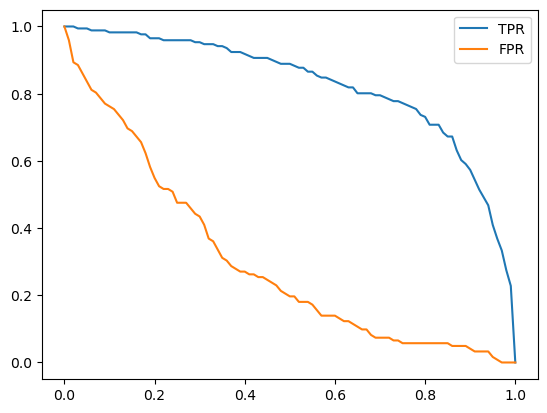

In [25]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

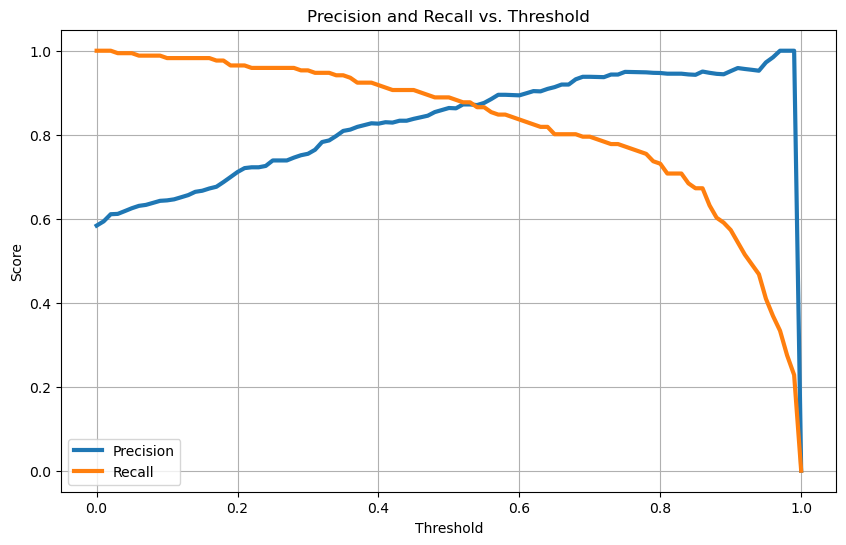


--- Question 3 Answer ---
Curves intersect at index: 100
Threshold at intersection: 1.000
Precision at intersection: 0.000
Recall at intersection: 0.000


In [ ]:
from sklearn.metrics import precision_score, recall_score

# 1. Generate an array of thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# 2. Create empty lists to store scores
precision_scores = []
recall_scores = []

# 3. Loop through each threshold
for t in thresholds:
    # Convert probabilities to binary predictions
    y_binary_pred = (y_pred >= t)
    
    # Calculate precision and recall
    # 'zero_division=0' prevents warnings when no positive predictions are made
    p = precision_score(y_val, y_binary_pred, zero_division=0)
    r = recall_score(y_val, y_binary_pred)
    
    # Append scores to their lists
    precision_scores.append(p)
    recall_scores.append(r)

# 4. Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', lw=3)
plt.plot(thresholds, recall_scores, label='Recall', lw=3)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.


Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54 <--
- 0.74


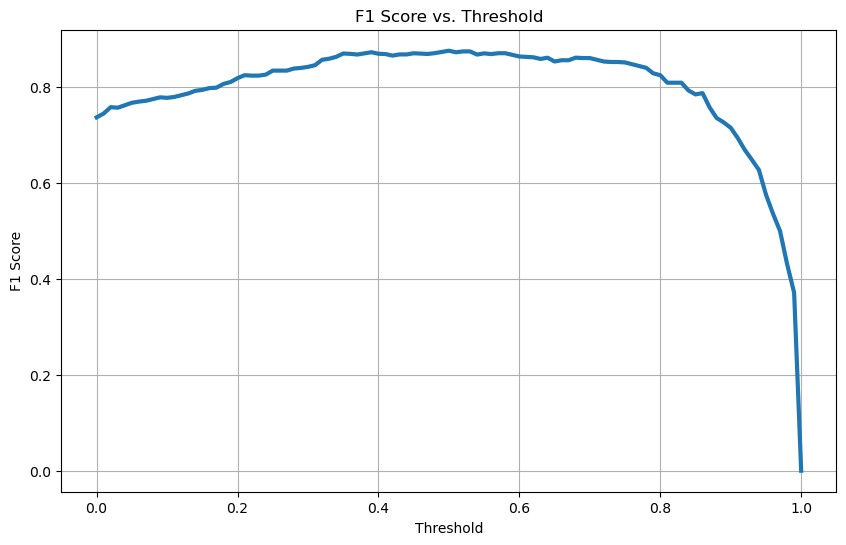


--- Question 4 Answer ---
Maximum F1 score of 0.8761 found at index: 50
This corresponds to a threshold of: 0.50


In [28]:
from sklearn.metrics import f1_score

# 1. Generate thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# 2. Create an empty list to store F1 scores
f1_scores = []

# 3. Loop through each threshold
for t in thresholds:
    # Convert probabilities to binary predictions
    y_binary_pred = (y_pred >= t)
    
    # Calculate the F1 score
    score = f1_score(y_val, y_binary_pred)
    
    # Append the score to our list
    f1_scores.append(score)

# 4. Plot the F1 score vs. Threshold (optional, but good to see)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', lw=3)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

# 5. Find the threshold that gives the maximum F1 score
# np.argmax finds the index of the largest value in the list
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

print("\n--- Question 4 Answer ---")
print(f"Maximum F1 score of {max_f1_score:.4f} found at index: {max_f1_index}")
print(f"This corresponds to a threshold of: {best_threshold:.2f}")

### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* `0.0001`
* `0.006`
* `0.06`  <-- wag, data produces 0.0358
* `0.36`


In [34]:
from sklearn.model_selection import KFold

# --- 1. Define Features and KFold ---

# These are the features specified in your problem description
categorical_features = [
    'lead_source', 
    'industry', 
    'employment_status', 
    'location'
]
numerical_features = [
    'number_of_courses_viewed', 
    'annual_income', 
    'interaction_count',
    'lead_score'
]

# KFold(n_splits=5, shuffle=True, random_state=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store the AUC score for each fold
scores = []

# --- 2. Iterate Over Folds ---

# kfold.split() generates indices for train/validation sets
for fold_n, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    print(f"--- Processing Fold {fold_n + 1} ---")
    
    # 2a. Split the data for this fold using the indices
    # We use .copy() to avoid SettingWithCopyWarning
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    # 2b. Get the target variable (y)
    y_train = df_train.converted.values
    y_val = df_val.converted.values

    # 2c. Remove target variable from features
    del df_train['converted']
    del df_val['converted']

    # --- 3. Preprocessing & Training (Inside the loop) ---
    
    # We must fit the vectorizer on the *training data for this fold*
    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # 4. Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # 5. Evaluate and store the score
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
    print(f"Fold {fold_n + 1} AUC: {auc:.4f}")


# --- 6. Calculate Final Statistics ---
print("\n--- Question 5 Answer ---")
print(f"All scores: {scores}")

mean_auc = np.mean(scores)
std_dev = np.std(scores)

print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")

--- Processing Fold 1 ---
Fold 1 AUC: 0.8061
--- Processing Fold 2 ---
Fold 2 AUC: 0.8714
--- Processing Fold 3 ---
Fold 3 AUC: 0.7754
--- Processing Fold 4 ---
Fold 4 AUC: 0.8018
--- Processing Fold 5 ---
Fold 5 AUC: 0.8558

--- Question 5 Answer ---
All scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC: 0.8221
Standard Deviation: 0.0358



### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

* `0.000001`
* `0.001`. <-- 
* `1`

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [35]:
# Parameters for the search
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store our final results
cv_results = []

# --- 2. Outer Loop: Iterate over C values ---
for C in C_values:
    print(f"--- Testing C = {C} ---")
    
    # List to store scores for the 5 folds
    fold_scores = []
    
    # --- 3. Inner Loop: 5-Fold Cross-Validation ---
    for fold_n, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        
        # 3a. Split the data for this fold
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        # 3b. Get the target variable (y)
        y_train = df_train.converted.values
        y_val = df_val.converted.values

        # 3c. Remove target variable from features
        del df_train['converted']
        del df_val['converted']

        # 3d. Preprocessing & Vectorization
        dv = DictVectorizer(sparse=False)
        train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        
        val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
        X_val = dv.transform(val_dict)

        # 3e. Train the model *with the current C*
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # 3f. Evaluate and store the score
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        fold_scores.append(auc)
    
    # --- 4. Calculate and Store Mean/Std for this C ---
    mean_auc = np.mean(fold_scores)
    std_auc = np.std(fold_scores)
    
    # Round to 3 decimal digits as requested
    mean_auc_rounded = round(mean_auc, 3)
    std_auc_rounded = round(std_auc, 3)
    
    print(f"Scores: {[round(s, 3) for s in fold_scores]}")
    print(f"C={C}: Mean AUC = {mean_auc_rounded}, Std = {std_auc_rounded}\n")
    
    # Store the results
    cv_results.append((C, mean_auc_rounded, std_auc_rounded))

# --- 5. Find the Best C Value ---
# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(cv_results, columns=['C', 'mean_auc', 'std_auc'])

# Sort by: 1. highest mean (desc), 2. lowest std (asc), 3. smallest C (asc)
results_df.sort_values(by=['mean_auc', 'std_auc', 'C'], 
                       ascending=[False, True, True], 
                       inplace=True)

print("--- Question 6 Answer ---")
print("Sorted Results:")
print(results_df)

best_result = results_df.iloc[0]
print(f"\nBest C value: {best_result['C']}")
print(f"Best Mean AUC: {best_result['mean_auc']}")
print(f"Std at Best: {best_result['std_auc']}")

--- Testing C = 1e-06 ---
Scores: [0.557, 0.519, 0.589, 0.558, 0.577]
C=1e-06: Mean AUC = 0.56, Std = 0.024

--- Testing C = 0.001 ---
Scores: [0.861, 0.897, 0.823, 0.854, 0.9]
C=0.001: Mean AUC = 0.867, Std = 0.029

--- Testing C = 1 ---
Scores: [0.806, 0.871, 0.775, 0.802, 0.856]
C=1: Mean AUC = 0.822, Std = 0.036

--- Question 6 Answer ---
Sorted Results:
          C  mean_auc  std_auc
1  0.001000     0.867    0.029
2  1.000000     0.822    0.036
0  0.000001     0.560    0.024

Best C value: 0.001
Best Mean AUC: 0.867
Std at Best: 0.029


## Submit the results

* Submit your results here: [https://courses.datatalks.club/ml-zoomcamp-2025/homework/](https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04)
* If your answer doesn't match options exactly, select the closest one